In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import csv

In [3]:
#define variables here:
path_to_data = 'drive/MyDrive/netflix/' #change this to the path of your netflix competition data directory

In [4]:
#Function to load all of the data into a pandas df
def load_netflix_data(file_paths):
    """Load Netflix data from multiple files into a single DataFrame."""
    data = {'user': [], 'item': [], 'label': []}
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            movie_id = None
            for line in file:
                line = line.strip()
                if line.endswith(':'):
                    movie_id = int(line[:-1])
                else:
                    customer_id, rating, _ = line.split(',')
                    data['item'].append(movie_id)
                    data['user'].append(int(customer_id))
                    data['label'].append(int(rating))
    return pd.DataFrame(data)

In [5]:
#load all of the netflix data into a pandas df
data_files = [f'{path_to_data}combined_data_{i}.txt' for i in range(1, 5)]
df = load_netflix_data(data_files)

In [6]:
#show some info about the df
print(len(df))
df.head()

100480507


,user,item,label
0,1488844,1,3
1,822109,1,5
2,885013,1,4
3,30878,1,4
4,823519,1,3


In [7]:
#Function to load the probe.txt file (which contains a list of user/movie pairs to be held off and used for testing), into a pandas df
def load_probe(file_path):
    """Load `probe.txt` into a DataFrame."""
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # Ignore empty or non-data lines
            line = line.strip()
            if line.endswith(':'):  # Skip MovieID lines
                current_movie_id = int(line[:-1])
            else:
                # CustomerID, MovieID
                customer_id = int(line)
                data.append({'item': current_movie_id, 'user': customer_id})
    return pd.DataFrame(data)

In [8]:
#Load the list of test user/movie pairs
probe_path = f'{path_to_data}probe.txt'
probe_df = load_probe(probe_path)

In [9]:
#Join the list of test user/movie pairs to the dataframe to create a df that contains the test user/movie pairs with the ground truth rating info
df_test = probe_df.merge(df, on=['item', 'user'], how='inner')

In [10]:
#show some info about the test df
print(len(df_test))
df_test.head()

1408395


,item,user,label
0,1,30878,4
1,1,2647871,4
2,1,1283744,3
3,1,2488120,5
4,1,317050,5


In [11]:
# Perform an anti-join to create a df with the rows in df that are not in df_test
df_train = pd.merge(
    df,
    df_test,
    on=['user', 'item'],
    how='left',
    indicator=True
)

# Keep only rows that are present in df but not in df_test
df_train = df_train[df_train['_merge'] == 'left_only'].drop(columns='_merge')

#get rid of unnecessary column names that were added by the code above
df_train = df_train.rename(columns={'label_x': 'label'}).drop(columns=['label_y'], errors='ignore')

In [12]:
#show some basic info about the train df
print(len(df_train))
df_train.head()

99072112


,user,item,label
0,1488844,1,3
1,822109,1,5
2,885013,1,4
4,823519,1,3
5,893988,1,3


In [13]:
#print the number of samples in each dataframe
print("Number of ALL samples:", len(df))
print("Number of train samples:", len(df_train))
print("Number of test samples:    ", len(df_test))

Number of ALL samples: 100480507
Number of train samples: 99072112
Number of test samples:     1408395


<h2>Data Visualizations:</h2>

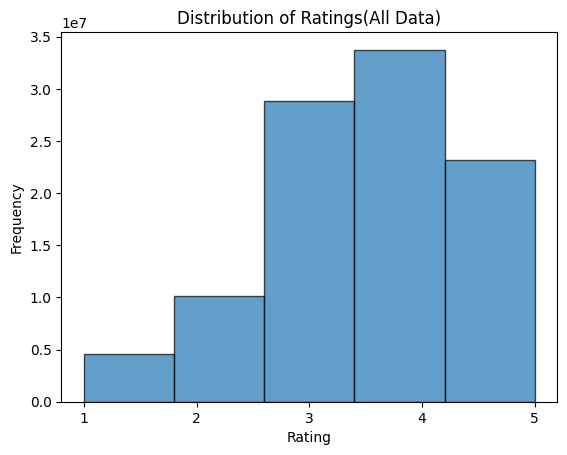

In [14]:
#Rating distributions for the entire dataset
plt.hist(df['label'], bins=5, edgecolor='black', alpha=0.7)
plt.title("Distribution of Ratings(All Data)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1, 6))
plt.show()

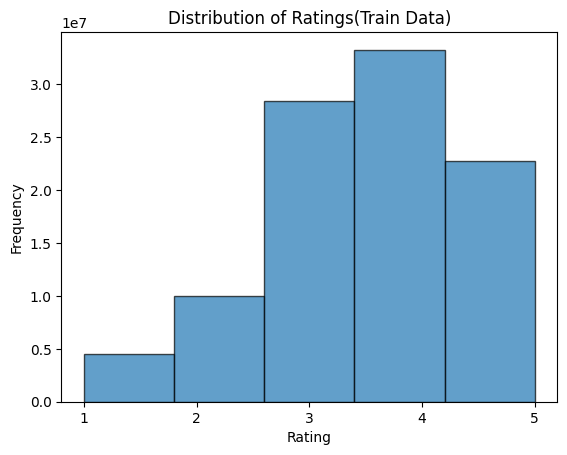

In [15]:
#Rating distributions for the training dataset
plt.hist(df_train['label'], bins=5, edgecolor='black', alpha=0.7)
plt.title("Distribution of Ratings(Train Data)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1, 6))
plt.show()

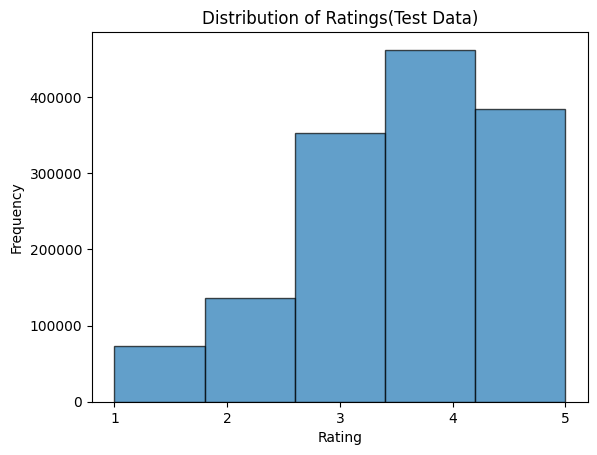

In [16]:
#Rating distributions for the test dataset
plt.hist(df_test['label'], bins=5, edgecolor='black', alpha=0.7)
plt.title("Distribution of Ratings(Test Data)")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.xticks(range(1, 6))
plt.show()

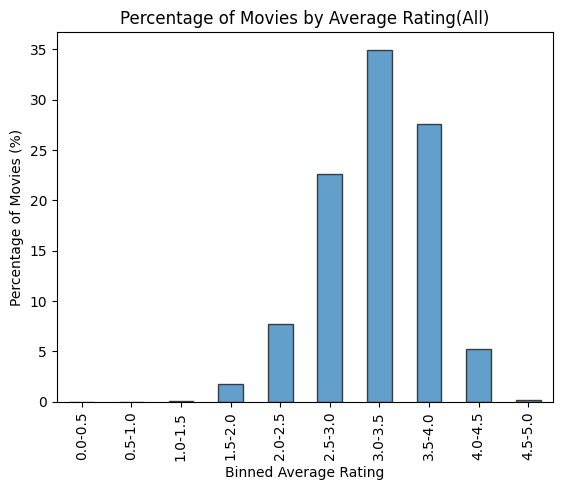

In [17]:
#Percentage of movies by binned average rating (all data)

# Bin average ratings into ranges
bins = np.arange(0, 5.5, 0.5)
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]
df['rating_bin'] = pd.cut(df.groupby('item')['label'].mean(), bins=bins, labels=labels)

# Count percentages in each bin
movie_rating_counts = df['rating_bin'].value_counts(normalize=True) * 100

# Plot
movie_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Movies by Average Rating(All)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Movies (%)")
plt.show()

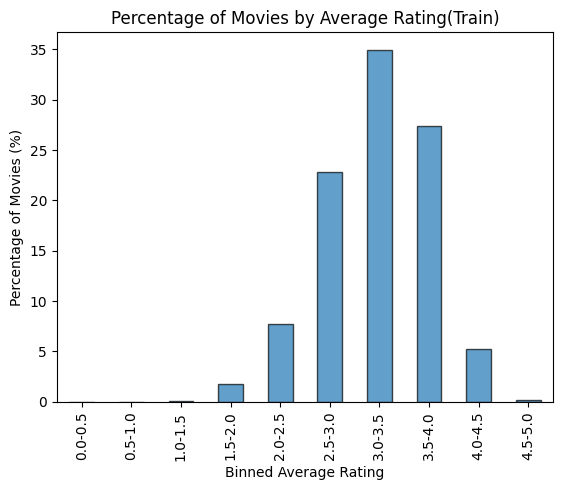

In [18]:
#Percentage of movies by binned average rating (training data)

# Bin average ratings into ranges
bins = np.arange(0, 5.5, 0.5)
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]
df_train['rating_bin'] = pd.cut(df_train.groupby('item')['label'].mean(), bins=bins, labels=labels)

# Count percentages in each bin
movie_rating_counts = df_train['rating_bin'].value_counts(normalize=True) * 100

# Plot
movie_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Movies by Average Rating(Train)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Movies (%)")
plt.show()

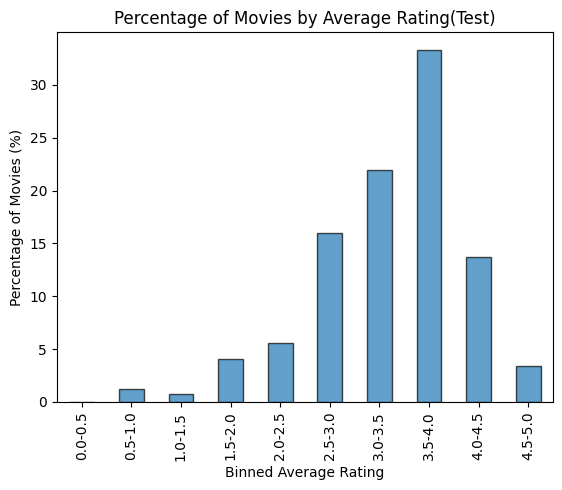

In [19]:
#Percentage of movies by binned average rating (test data)

# Bin average ratings into ranges
bins = np.arange(0, 5.5, 0.5)  # Adjust bin size as needed
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]
df_test['rating_bin'] = pd.cut(df_test.groupby('item')['label'].mean(), bins=bins, labels=labels)

# Count percentages in each bin
movie_rating_counts = df_test['rating_bin'].value_counts(normalize=True) * 100

# Plot
movie_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Movies by Average Rating(Test)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Movies (%)")
plt.show()

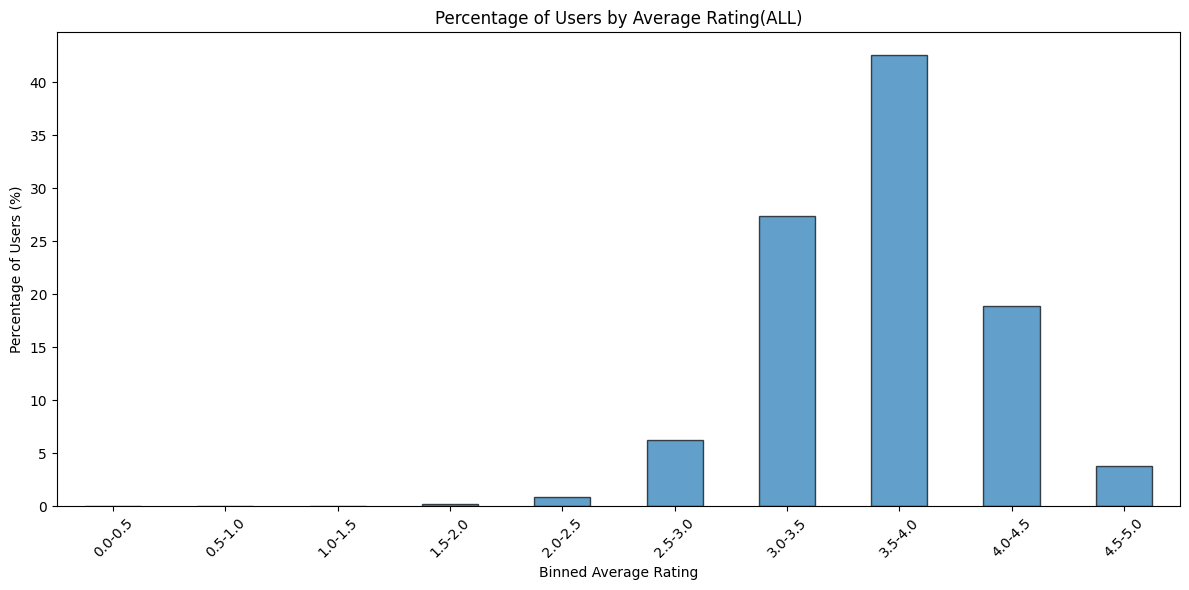

In [20]:
#Percentage of users by average binned rating (all data)

# Define bins for user average ratings
bins = np.arange(0, 5.5, 0.5)
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]  # Bin labels

# Bin the user average ratings
df['user_rating_bin'] = pd.cut(df.groupby('user')['label'].mean(), bins=bins, labels=labels)

# Count percentages for each bin
user_rating_counts = df['user_rating_bin'].value_counts(normalize=True) * 100

# Plot the binned data
plt.figure(figsize=(12, 6))  # Adjust figure size
user_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Users by Average Rating(ALL)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Users (%)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

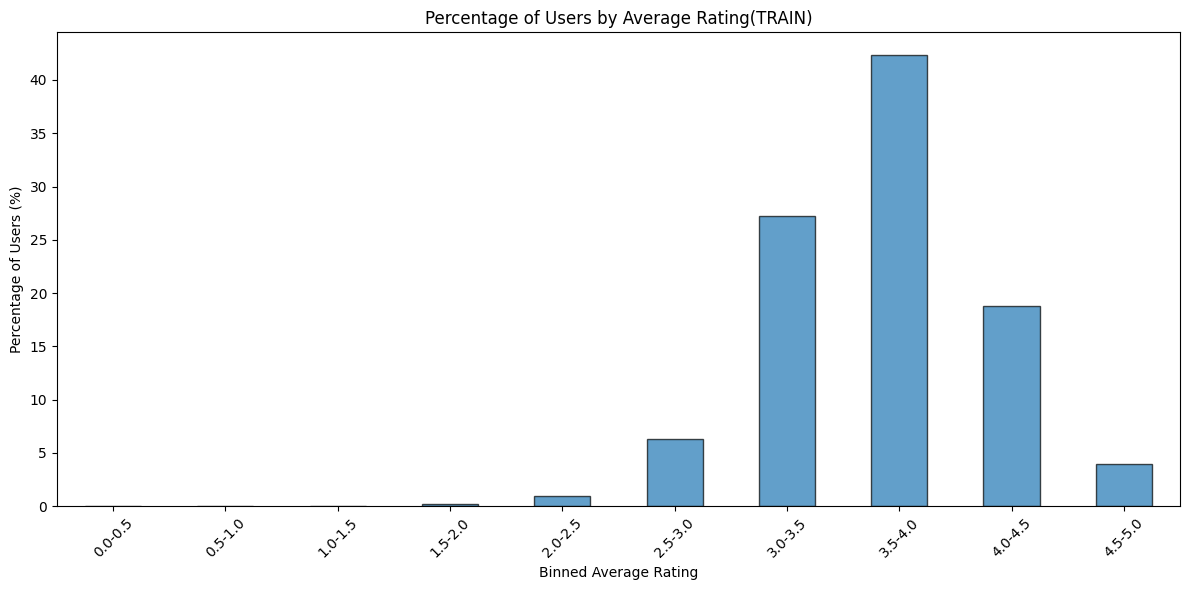

In [21]:
#Percentage of users by average binned rating (training data)

# Define bins for user average ratings
bins = np.arange(0, 5.5, 0.5)
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]  # Bin labels

# Bin the user average ratings
df_train['user_rating_bin'] = pd.cut(df_train.groupby('user')['label'].mean(), bins=bins, labels=labels)

# Count percentages for each bin
user_rating_counts = df_train['user_rating_bin'].value_counts(normalize=True) * 100

# Plot the binned data
plt.figure(figsize=(12, 6))  # Adjust figure size
user_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Users by Average Rating(TRAIN)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Users (%)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

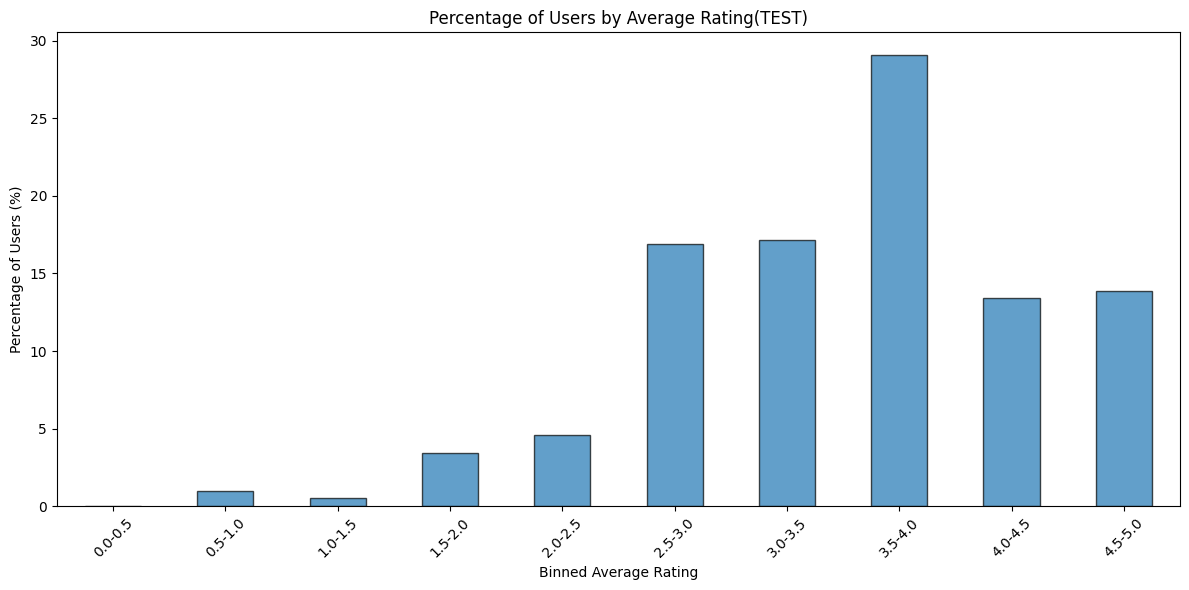

In [22]:
#Percentage of users by average binned rating (test data)

# Define bins for user average ratings
bins = np.arange(0, 5.5, 0.5)
labels = [f"{i:.1f}-{i+0.5:.1f}" for i in bins[:-1]]  # Bin labels

# Bin the user average ratings
df_test['user_rating_bin'] = pd.cut(df_test.groupby('user')['label'].mean(), bins=bins, labels=labels)

# Count percentages for each bin
user_rating_counts = df_test['user_rating_bin'].value_counts(normalize=True) * 100

# Plot the binned data
plt.figure(figsize=(12, 6))  # Adjust figure size
user_rating_counts.sort_index().plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Percentage of Users by Average Rating(TEST)")
plt.xlabel("Binned Average Rating")
plt.ylabel("Percentage of Users (%)")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.tight_layout()
plt.show()

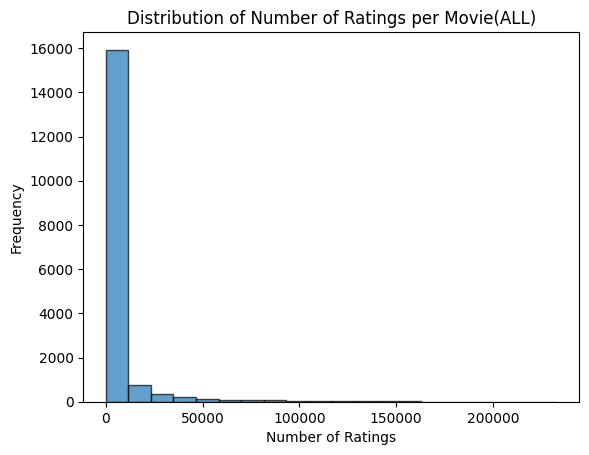

In [23]:
#Distribution of ratings per movie for all of the data

movie_rating_counts = df.groupby('item')['label'].count()

movie_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per Movie(ALL)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

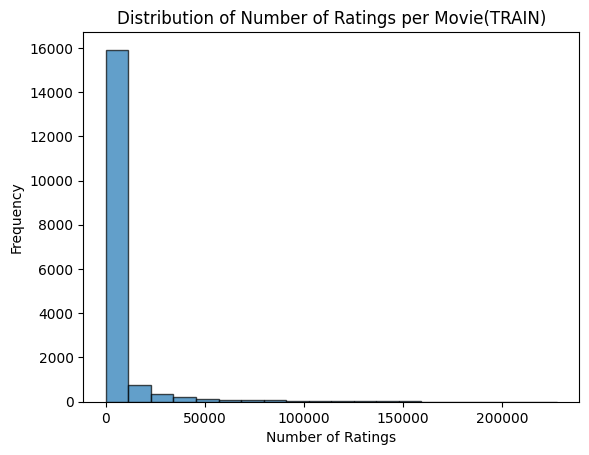

In [24]:
#Distribution of ratings per movie for the training data

movie_rating_counts = df_train.groupby('item')['label'].count()

movie_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per Movie(TRAIN)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

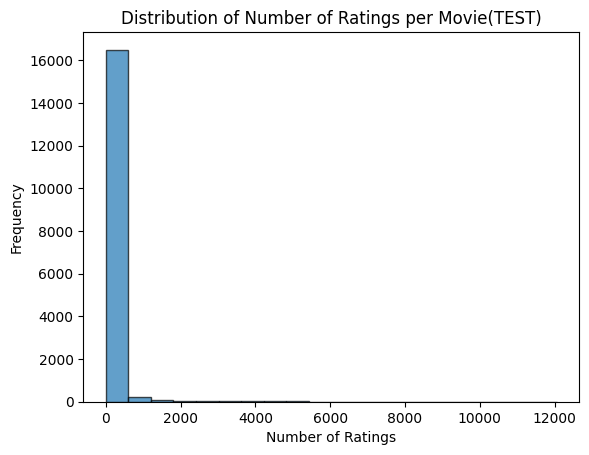

In [25]:
#Distribution of ratings per movie for the test data

movie_rating_counts = df_test.groupby('item')['label'].count()

movie_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per Movie(TEST)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

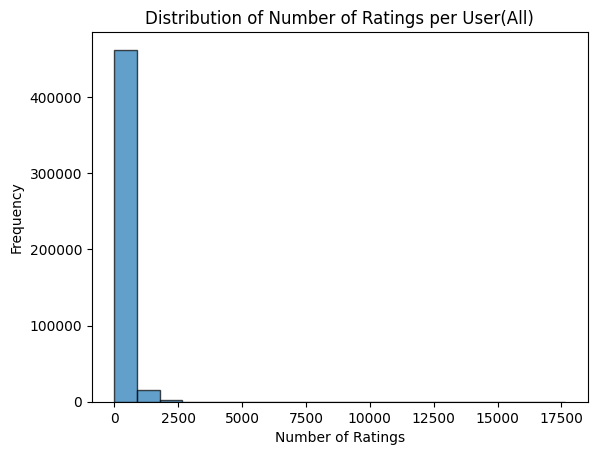

In [26]:
#Distribution of ratings per user for all of the data

user_rating_counts = df.groupby('user')['label'].count()

user_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per User(All)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

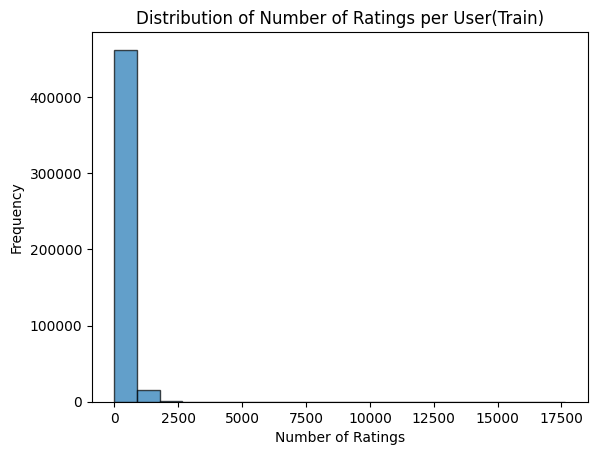

In [27]:
#Distribution of ratings per user for the training data

user_rating_counts = df_train.groupby('user')['label'].count()

user_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per User(Train)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

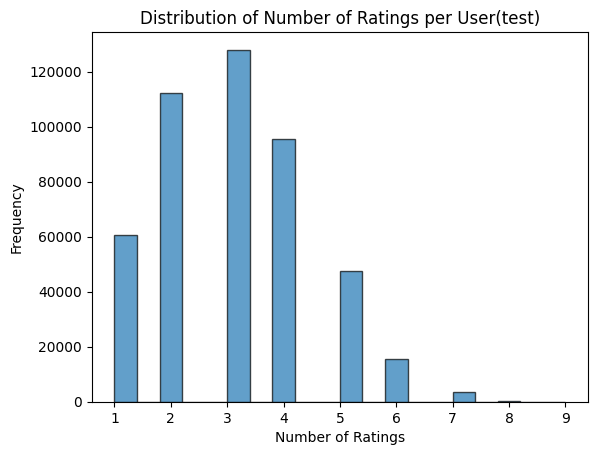

In [28]:
#Distribution of ratings per user for the test data

user_rating_counts = df_test.groupby('user')['label'].count()

user_rating_counts.plot(kind='hist', bins=20, edgecolor='black', alpha=0.7)
plt.title("Distribution of Number of Ratings per User(test)")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

In [29]:
#Modify the 'movie_titles.csv' file to wrap every movie title in quotes

# Input and output file paths
input_file = f'{path_to_data}movie_titles.csv'
output_file = f'{path_to_data}movie_titles_quoted.csv'

# Open the input file and create a new output file
with open(input_file, 'r', encoding='ISO-8859-1') as infile, open(output_file, 'w', encoding='ISO-8859-1', newline='') as outfile:
    reader = csv.reader(infile)
    writer = csv.writer(outfile, quoting=csv.QUOTE_NONNUMERIC)

    # Process each row
    for row in reader:
        # Assume first two fields are MovieID and Year, and the rest is the Title
        movie_id = row[0]  # First column
        year = row[1]      # Second column
        title = ','.join(row[2:])  # Combine remaining parts into one title string
        writer.writerow([movie_id, year, title])  # Write corrected row

print(f"Fixed CSV saved to {output_file}")

Fixed CSV saved to drive/MyDrive/netflix/movie_titles_quoted.csv


In [30]:
#Create a df from the movie titles csv files that maps movie ids to movie titles
movie_df = pd.read_csv(f"{path_to_data}movie_titles_quoted.csv", header=None, names=['MovieID', 'Year', 'Title'], encoding='ISO-8859-1', quotechar='"')
movie_df.head()

,MovieID,Year,Title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


In [31]:
#make a dictionary from the dataframe that maps movie IDs to movie titles
movie_id_to_title = dict(zip(movie_df['MovieID'], movie_df['Title']))

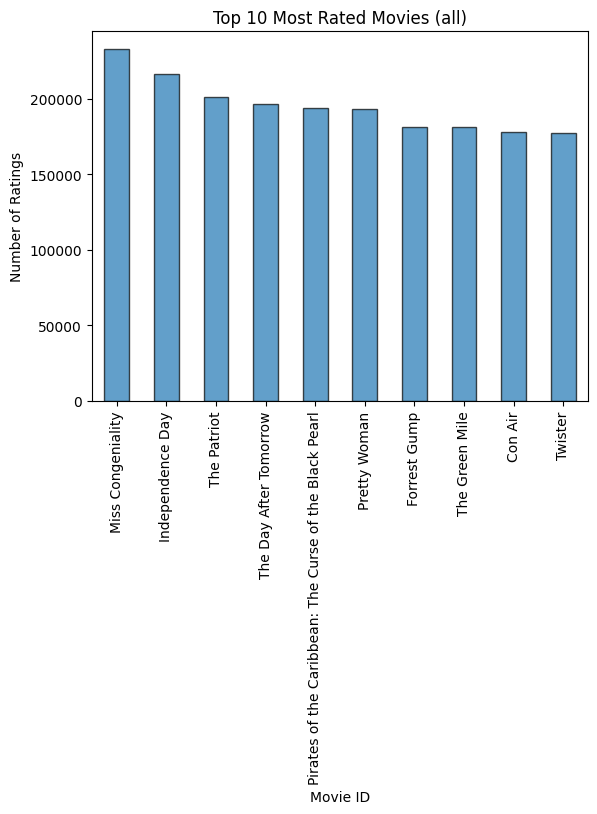

In [32]:
#display the top 10 most rated movies for all of the data

top_movies = df.groupby('item')['label'].count().sort_values(ascending=False).head(10)

top_movies.index = top_movies.index.map(movie_id_to_title)

top_movies.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Top 10 Most Rated Movies (all)")
plt.xlabel("Movie ID")
plt.ylabel("Number of Ratings")
plt.show()

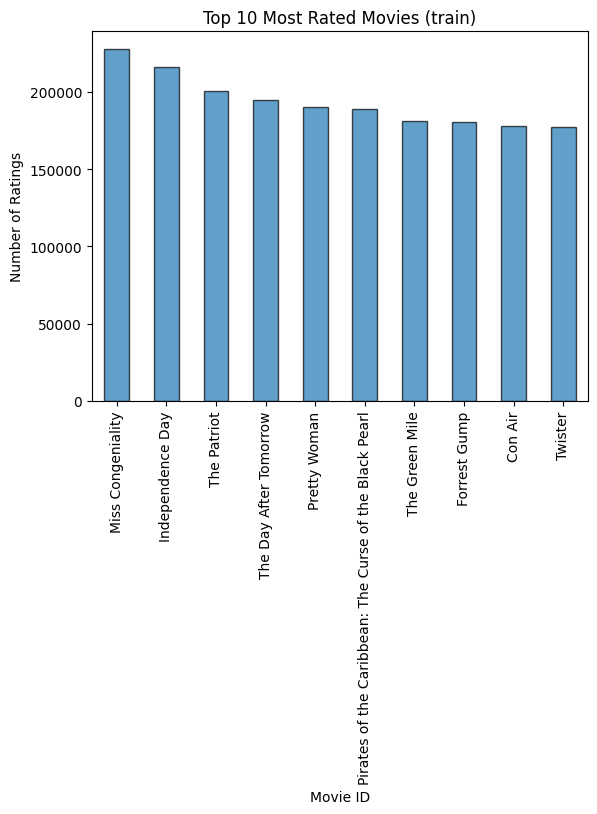

In [33]:
#display the top 10 most rated movies for the training data

top_movies = df_train.groupby('item')['label'].count().sort_values(ascending=False).head(10)

top_movies.index = top_movies.index.map(movie_id_to_title)

top_movies.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Top 10 Most Rated Movies (train)")
plt.xlabel("Movie ID")
plt.ylabel("Number of Ratings")
plt.show()

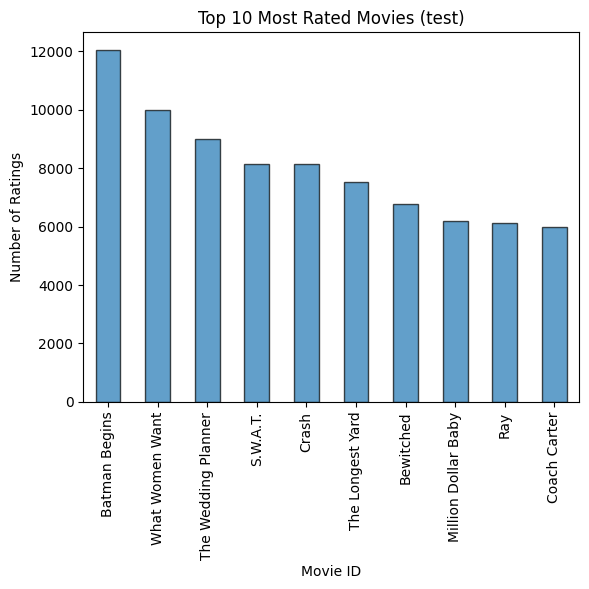

In [34]:
#display the top 10 most rated movies for the test data

top_movies = df_test.groupby('item')['label'].count().sort_values(ascending=False).head(10)

top_movies.index = top_movies.index.map(movie_id_to_title)

top_movies.plot(kind='bar', edgecolor='black', alpha=0.7)
plt.title("Top 10 Most Rated Movies (test)")
plt.xlabel("Movie ID")
plt.ylabel("Number of Ratings")
plt.show()

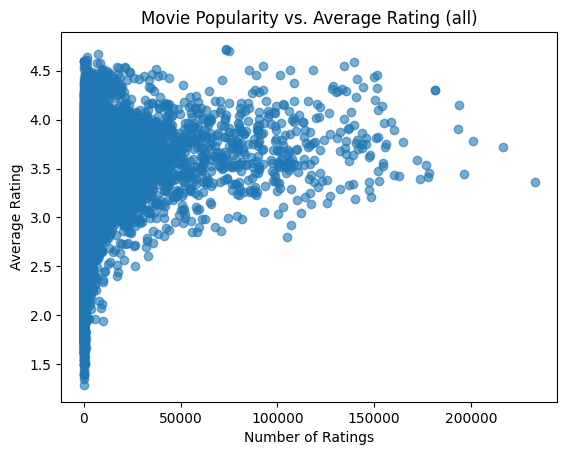

In [35]:
#number of ratings for a movie vs. average rating for the movie scatterplot for all of the data

movie_stats = df.groupby('item').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(movie_stats['rating_count'], movie_stats['avg_rating'], alpha=0.6)
plt.title("Movie Popularity vs. Average Rating (all)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

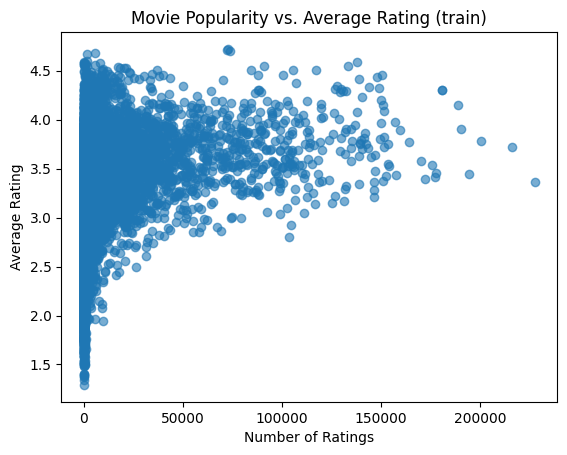

In [36]:
#number of ratings for a movie vs. average rating for the movie scatterplot for the training data

movie_stats = df_train.groupby('item').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(movie_stats['rating_count'], movie_stats['avg_rating'], alpha=0.6)
plt.title("Movie Popularity vs. Average Rating (train)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

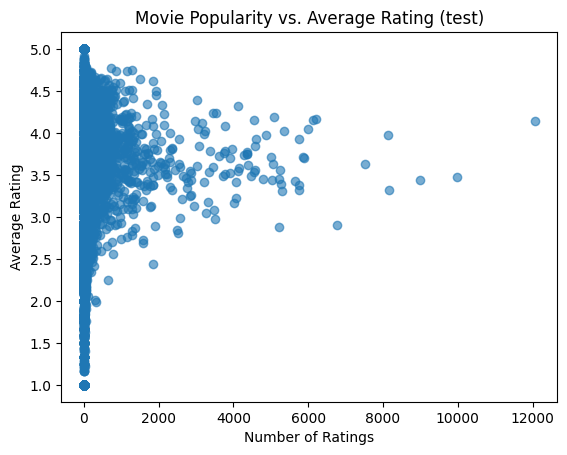

In [37]:
#number of ratings for a movie vs. average rating for the movie scatterplot for the test data

movie_stats = df_test.groupby('item').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(movie_stats['rating_count'], movie_stats['avg_rating'], alpha=0.6)
plt.title("Movie Popularity vs. Average Rating (test)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

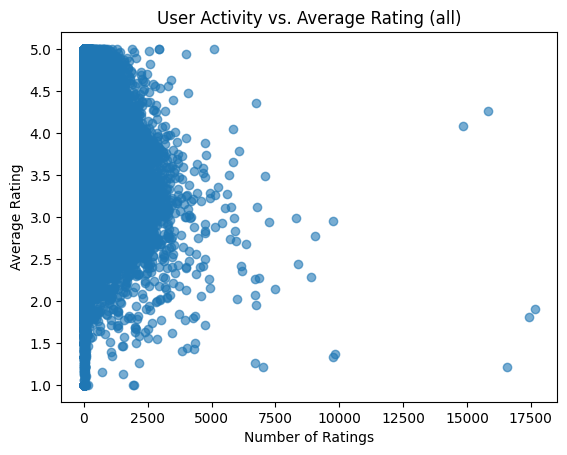

In [38]:
#number of movies a user rated vs. average rating scatterplot for all of the data

user_stats = df.groupby('user').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(user_stats['rating_count'], user_stats['avg_rating'], alpha=0.6)
plt.title("User Activity vs. Average Rating (all)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

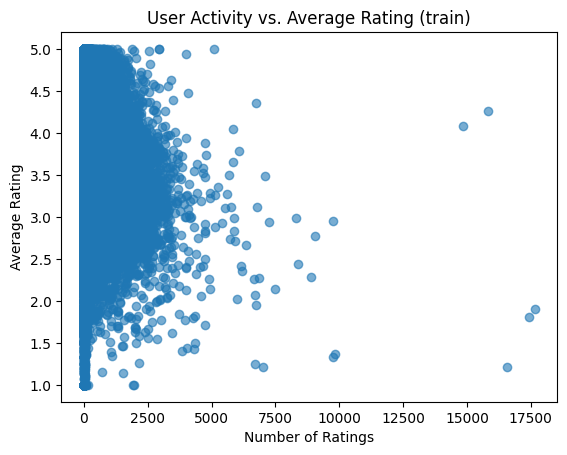

In [39]:
#number of movies a user rated vs. average rating scatterplot for the training data

user_stats = df_train.groupby('user').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(user_stats['rating_count'], user_stats['avg_rating'], alpha=0.6)
plt.title("User Activity vs. Average Rating (train)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

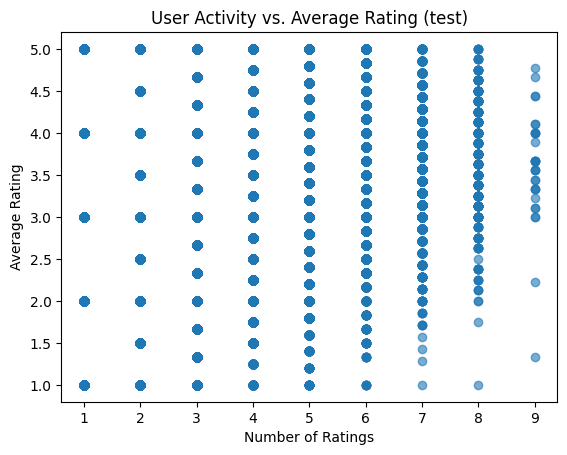

In [40]:
#number of movies a user rated vs. average rating scatterplot for the test data

user_stats = df_test.groupby('user').agg(
    rating_count=('label', 'count'),
    avg_rating=('label', 'mean')
)

plt.scatter(user_stats['rating_count'], user_stats['avg_rating'], alpha=0.6)
plt.title("User Activity vs. Average Rating (test)")
plt.xlabel("Number of Ratings")
plt.ylabel("Average Rating")
plt.show()

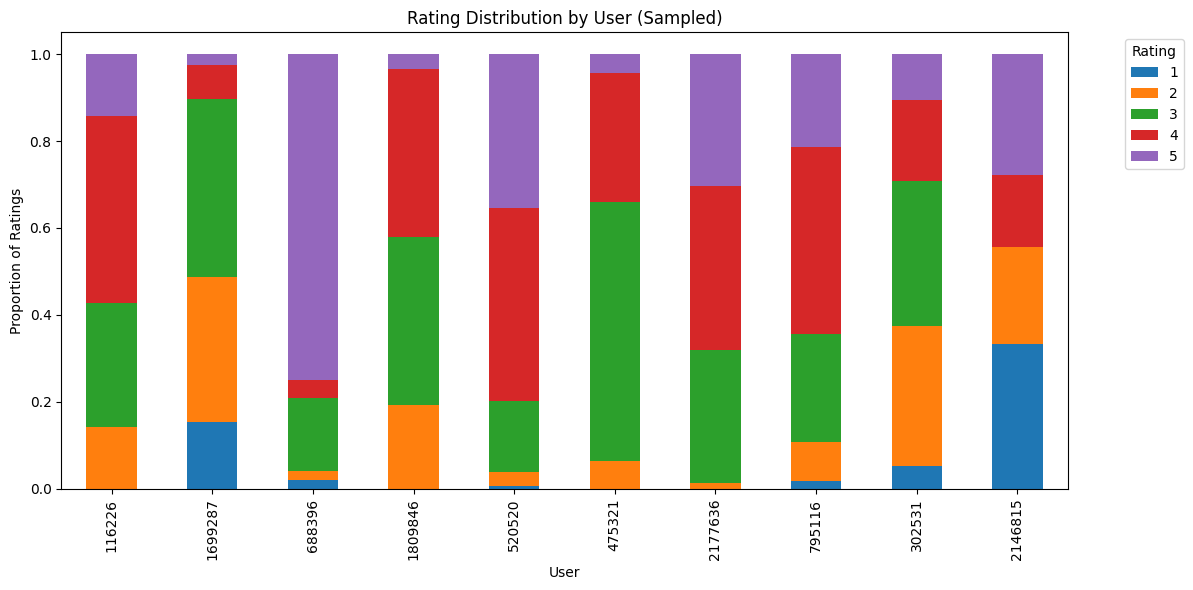

In [41]:
#Rating distribution for 10 randomly sampled users


user_ratings = df.groupby('user')['label'].value_counts(normalize=True).unstack().fillna(0)

user_ratings.sample(10).plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Rating Distribution by User (Sampled)")
plt.xlabel("User")
plt.ylabel("Proportion of Ratings")
plt.legend(title="Rating", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<h2>Other Metrics:</h2>

In [42]:
# Top 20 most rated movies
most_rated_movies = df.groupby('item').size().sort_values(ascending=False).head(20)

# Create a DataFrame from the results and add a new column for the movie names
most_rated_movies_df = most_rated_movies.reset_index()  # Reset the index to convert it to a column
most_rated_movies_df.rename(columns={0: 'rating_count'}, inplace=True)  # Rename the column if needed
most_rated_movies_df['movie_name'] = most_rated_movies_df['item'].map(movie_id_to_title)

print("Top 20 Most Rated Movies:")
print(most_rated_movies_df)

Top 20 Most Rated Movies:
     item  rating_count                                         movie_name
0    5317        232944                                  Miss Congeniality
1   15124        216596                                   Independence Day
2   14313        200832                                        The Patriot
3   15205        196397                             The Day After Tomorrow
4    1905        193941  Pirates of the Caribbean: The Curse of the Bla...
5    6287        193295                                       Pretty Woman
6   11283        181508                                       Forrest Gump
7   16377        181426                                     The Green Mile
8   16242        178068                                            Con Air
9   12470        177556                                            Twister
10  15582        176539                                 Sweet Home Alabama
11   9340        173596                                       Pearl Harbor

In [43]:
# Top 20 movies with the highest average rating
highest_avg_rating = df.groupby('item')['label'].mean().sort_values(ascending=False).head(20)

# Create a DataFrame from the results and add a new column for the movie names
highest_avg_rating_df = highest_avg_rating.reset_index()  # Reset the index to convert it to a column
highest_avg_rating_df.rename(columns={0: 'avg_rating'}, inplace=True)  # Rename the column if needed
highest_avg_rating_df['movie_name'] = highest_avg_rating_df['item'].map(movie_id_to_title)

print("Top 20 Movies with the Highest Average Rating:")
print(highest_avg_rating_df)


Top 20 Movies with the Highest Average Rating:
     item     label                                         movie_name
0   14961  4.723270  Lord of the Rings: The Return of the King: Ext...
1    7230  4.716611  The Lord of the Rings: The Fellowship of the R...
2    7057  4.702611  Lord of the Rings: The Two Towers: Extended Ed...
3    3456  4.670989                                     Lost: Season 1
4    9864  4.638809                     Battlestar Galactica: Season 1
5   15538  4.605021                                Fullmetal Alchemist
6   14791  4.600000                        Trailer Park Boys: Season 3
7    8964  4.600000                        Trailer Park Boys: Season 4
8   10464  4.595506                              Tenchi Muyo! Ryo Ohki
9   14550  4.593384          The Shawshank Redemption: Special Edition
10  12398  4.592084                            Veronica Mars: Season 1
11   3033  4.586364   Ghost in the Shell: Stand Alone Complex: 2nd Gig
12   7833  4.582389           

In [44]:
# Top 20 movies with the highest total rating points
highest_total_rating = df.groupby('item')['label'].sum().sort_values(ascending=False).head(20)

# Create a DataFrame from the results and add a new column for the movie names
highest_total_rating_df = highest_total_rating.reset_index()  # Reset the index to convert it to a column
highest_total_rating_df.rename(columns={0: 'avg_rating'}, inplace=True)  # Rename the column if needed
highest_total_rating_df['movie_name'] = highest_total_rating_df['item'].map(movie_id_to_title)


print("Top 20 Movies with the Highest Total Rating Points:")
print(highest_total_rating_df)

Top 20 Movies with the Highest Total Rating Points:
     item   label                                         movie_name
0   15124  806655                                   Independence Day
1    1905  805613  Pirates of the Caribbean: The Curse of the Bla...
2    5317  782987                                  Miss Congeniality
3   16377  781391                                     The Green Mile
4   11283  780468                                       Forrest Gump
5   14313  759919                                        The Patriot
6    6287  754826                                       Pretty Woman
7   15205  676031                             The Day After Tomorrow
8   11521  674655                  Lord of the Rings: The Two Towers
9    2452  664612      Lord of the Rings: The Fellowship of the Ring
10   4306  654375                                    The Sixth Sense
11  14550  641512          The Shawshank Redemption: Special Edition
12   3938  638243                                  